In [45]:
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import cv2
import numpy as np
import imgaug as im
import pandas as pd
import os
import random

from osgeo import gdal, ogr, osr 
from numpy import nan
from PIL import Image

env: SM_FRAMEWORK=tf.keras


In [46]:
def find_dominant_color(img, width=256, height=256):
    image = img.resize((width, height),resample = 0)
    pixels = image.getcolors(width * height)
    sorted_pixels = sorted(pixels, key=lambda t: t[0])
    dominant_color = sorted_pixels[-1][1]

    return dominant_color

In [5]:
def statistic_data_per_channels(img, consider_black_pixes=True, only_histrogram=False):
        """
        Description: 
        
            Metodo responsável por percorrer cada componente do array em cada canal e verifica-lo.
            São feito tratamentos para casos onde o valor do pixel é igual a zero, analisando através
            do booleano consider_black_pixes, se o valor zero é relevante ou não para a analise 
            da imagem em questão.
            
        Args:
            
            img {array}: É a imagem que será utilizada para os levantar os dados de media e desvio padão
            consider_black_pixes {bool} : Responsável para considerar se os pixels pretos são importantes
            ou não na analise
            
        Returns:
            
            [metrics_ch1, metrics_ch2, metrics_ch3]: Media e o desvio padrao para cada canal da imagem
        
        """

        count_pixels = 0
        pixels_array_ch1 = []
        pixels_array_ch2 = []
        pixels_array_ch3 = []
        count_black_pixels = 0
        
        rows, cols, number_channels = img.shape
        
        if consider_black_pixes:
            for channel in range(number_channels):
                for i in range(rows):
                    for j in range(cols):

                        count_pixels += 1
                        pixel_value = img[i,j, channel]

                        if pixel_value == 0:
                            count_black_pixels += 1
                            continue

                        if channel == 0:
                            pixels_array_ch1.append(pixel_value)

                        elif channel == 1:
                            pixels_array_ch2.append(pixel_value)

                        elif channel == 2:
                            pixels_array_ch3.append(pixel_value)
            
            if only_histrogram:

                metrics_ch1 = [pixels_array_ch1]
                metrics_ch2 = [pixels_array_ch2]
                metrics_ch3 = [pixels_array_ch3]

            # Situacao comum
            else:

                metrics_ch1 = [np.mean(pixels_array_ch1)]
                metrics_ch2 = [np.mean(pixels_array_ch2)]
                metrics_ch3 = [np.mean(pixels_array_ch3)]

        else:

            metrics_ch1 = [np.mean(img[:,:,0])]
            metrics_ch2 = [np.mean(img[:,:,1])]
            metrics_ch3 = [np.mean(img[:,:,2])]
            
        return [metrics_ch1, metrics_ch2, metrics_ch3]

In [6]:
def show_avg_color(array_avg_color, size_x=100, size_y=100, show_img=True):
    _img = np.zeros([100,100,3], dtype=np.uint8)
    for i in range(len(array_avg_color)):
        _img[:,:,i] = np.ones([size_x, size_y]) * array_avg_color[i]
    
    if show_img:
        im.imshow(_img)
    
    return _img

In [20]:
def defines_max_values(gdal_obj, max_x=-1, max_y=-1):
    if max_x == -1:
            max_x = gdal_obj.RasterXSize

    if max_y == -1:
        max_y = gdal_obj.RasterYSize

    if gdal_obj is not None: 
        _num_bands = mosaico.RasterCount
        if _num_bands < 3:
            #print('ERROR, This method works only for orthomosaics with more of 3 bands and you have : ', _num_bands)
            pass
            
    return _num_bands, max_x, max_y 

In [8]:
def estimate_dominant_color_orthomosaic(gdal_obj, init_x, init_y, max_x=-1, max_y=-1, increment_x=256, increment_y=256, percent_allowed_black=0.5, consider_black=True, show_img=False):
     
    _num_bands, max_x, max_y = defines_max_values(gdal_obj, max_x, max_y)
    channel_1, channel_2, channel_3 = [],[],[]
    for x in range(init_x, max_x, increment_x):
        for y in range(init_y, max_y, increment_y):
            if ((x+increment_x) > gdal_obj.RasterXSize) or ((y+increment_x) > gdal_obj.RasterYSize):
                continue
                
            _img_b, _img_g, _img_r = patch_orthomosaic_array(gdal_obj, x, y, increment_x, increment_y)
            
            if (cv2.countNonZero(_img_b) + cv2.countNonZero(_img_g) + cv2.countNonZero(_img_r)) < int(increment_x * increment_y * (1-percent_allowed_black) * (_num_bands-1)):
                continue
                
            _img = cv2.merge((_img_b, _img_g, _img_r))
            _img = Image.fromarray(_img)
            values_color = find_dominant_color(_img)
            var = [values_color[i] if values_color[i] != [nan] else [0] for i in range(len(values_color))]
            channel_1.append(var[0])
            channel_2.append(var[1])
            channel_3.append(var[2])

    if consider_black:
        total = [[np.sum(channel_1)/(len(channel_1) - channel_1.count([0]))],
                 [np.sum(channel_2)/(len(channel_2) - channel_2.count([0]))],
                 [np.sum(channel_3)/(len(channel_3) - channel_3.count([0]))]]

    else:
        total = [[np.mean(channel_1)],
                 [np.mean(channel_2)],
                 [np.mean(channel_3)]]

        
    _img = show_avg_color(total, show_img=show_img)
    
    return _img

In [9]:
def walker_orthomosaic(gdal_obj, percent_allowed_black, init_x, init_y, max_x=-1, max_y=-1, increment_x=256, increment_y=256):
    _num_bands, max_x, max_y = defines_max_values(gdal_obj, max_x, max_y)
    for x in range(init_x, max_x, increment_x):
        for y in range(init_y, max_y, increment_y):
            if ((x+increment_x) > gdal_obj.RasterXSize) or ((y+increment_x) > gdal_obj.RasterYSize):
                continue
            
            _img_b, _img_g, _img_r = patch_orthomosaic_array(gdal_obj, x, y, increment_x, increment_y)
            if (cv2.countNonZero(_img_b) + cv2.countNonZero(_img_g) + cv2.countNonZero(_img_r)) < int(increment_x * increment_y * (1-percent_allowed_black) * (_num_bands-1)):
                continue

            _img = cv2.merge((_img_b, _img_g, _img_r))
            _img = cv2.cvtColor(_img, cv2.COLOR_BGR2RGB)
            
            im.imshow(_img)

In [10]:
def random_func(*, percentage: int) -> int:
    '''
    percentage: Valores entre 0 e 100. Caso value > percentag é retornado true, caso não
    é retornado false
    
    description: Utilizada para definir se a função de pré processamento será utilizada ou
    não. 
    
    return:
    bool
    '''
    _value = random.randint(0, 100)
    if _value < percentage:
        #print(_value)
        return False
    else:
        #print(_value)
        return True

In [11]:
def iteration_with_user():
    _type_learning = ''
    _path_dir = 'dataset'
    while _type_learning != 0 or _type_learning != 1:
        _type_learning = int(input('Selecione o tipo de Aprendizado: [0/1] - 0:Supervisionado, 1:Não Supervisionado'))
        if _type_learning == 0:
            paths_array = [str(_path_dir + '/train'), str(_path_dir + '/mask_train'), 
                           str(_path_dir + '/validation'), str(_path_dir + '/mask_validation')]

            if not os.path.exists(_path_dir):
                for i in range(len(paths_array)):
                    os.makedirs(str(paths_array[i]), exist_ok=True)
            break
            
        elif _type_learning == 1:
            paths_array = [str(_path_dir + '/train/weed'), str(_path_dir + '/train/soil'), 
                           str(_path_dir + '/validation/weed'), str(_path_dir + '/validation/soil')]
            
            if not os.path.exists(_path_dir):
                for i in range(len(paths_array)):
                    os.makedirs(str(paths_array[i]), exist_ok=True)
            
            break
    
    return paths_array

In [15]:
def generate_dataset(path_orthomosaic, path_ground_true, percent_allowed_black, 
                     init_x, init_y, max_x=-1, max_y=-1, increment_x=256, increment_y=256, 
                     percent_train=0.7, num_images=-1, type_learning='supervisionated', 
                     current_id='0', invert_img = False,):

    _orthomosaic_rgb = gdal.Open(path_orthomosaic)
    _ground_true = gdal.Open(path_ground_true)
    _num_bands, max_x, max_y = defines_max_values(_orthomosaic_rgb, max_x, max_y)
    paths_array = iteration_with_user()
    
    if current_id == '0':
        current_id = '/'.rstrip() + str(random.randint(1000, 10000))
    
    for x in range(init_x, max_x, increment_x):
        for y in range(init_y, max_y, increment_y):
            
            _img_b, _img_g, _img_r = patch_orthomosaic_array(_orthomosaic_rgb, x, y, increment_x, increment_y)
            
            if ((x+increment_x) > _orthomosaic_rgb.RasterXSize) or ((y+increment_x) > _orthomosaic_rgb.RasterYSize):
                continue

            _img_gt_b, _img_gt_g, _img_gt_r = patch_orthomosaic_array(_ground_true, x, y, increment_x,increment_y, invert_img)        
            _img_ground_true = cv2.merge((_img_gt_b, _img_gt_g, _img_gt_r))
            _img_ground_true = cv2.cvtColor(_img_ground_true, cv2.COLOR_BGR2GRAY)
            _img_ground_true = cv2.threshold(_img_ground_true,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

            if type_learning == 'supervisionated':
                if cv2.countNonZero(_img_ground_true) > 0:
                    if (cv2.countNonZero(_img_b) + cv2.countNonZero(_img_g) + cv2.countNonZero(_img_r)) < int(increment_x * increment_y * (1-percent_allowed_black) * (_num_bands-1)):
                        continue
                        
                    _img = cv2.merge((_img_r, _img_g, _img_b))
                    _img = cv2.cvtColor(_img, cv2.COLOR_BGR2RGB)

                    if random_func(percentage = (1 - percent_train) * 100):
                        cv2.imwrite(str(paths_array[0] + current_id + '_daninha_{x}_{y}.png').format(x=x,y=y), _img)
                        cv2.imwrite(str(paths_array[1] + current_id + '_daninha_{x}_{y}.png').format(x=x,y=y), _img_ground_true)
                                   
                    else:
                        cv2.imwrite(str(paths_array[2] + current_id + '_daninha_{x}_{y}.png').format(x=x,y=y), _img)
                        cv2.imwrite(str(paths_array[3] + current_id + '_daninha_{x}_{y}.png').format(x=x,y=y), _img_ground_true)       
   
            elif type_learning == 'unsupervisionated':
                if (cv2.countNonZero(_img_b) + cv2.countNonZero(_img_g) + cv2.countNonZero(_img_r)) < int(increment_x * increment_y * (1-percent_allowed_black) * (_num_bands-1)):
                    continue
                
                _img = cv2.merge((_img_r, _img_g, _img_b))
                _img = cv2.cvtColor(_img, cv2.COLOR_BGR2RGB)
                                   
                if cv2.countNonZero(_img_ground_true) > 0:
                    if random_func(percentage = (1 - percent_train) * 100):
                        cv2.imwrite(str(paths_array[0] + current_id + '_daninha_{x}_{y}.png').format(x=x,y=y), _img)

                    else:
                        cv2.imwrite(str(paths_array[2] + current_id + '_daninha_{x}_{y}.png').format(x=x,y=y), _img)    
                else:
                    if random_func(percentage = (1 - percent_train) * 100):
                        cv2.imwrite(str(paths_array[1] + current_id + '_daninha_{x}_{y}.png').format(x=x,y=y), _img)

                    else:
                        cv2.imwrite(str(paths_array[3] + current_id + '_daninha_{x}_{y}.png').format(x=x,y=y), _img)    


In [12]:
def patch_orthomosaic_array(gdal_obj, pos_x, pos_y, increment_x, increment_y, invert_img = False):
    total_layers  = [[]] * 4
    for i in range(1, len(total_layers), 1):
        try:
            #print(i, 'certo')
            total_layers[i] = gdal_obj.GetRasterBand(i).ReadAsArray(pos_x, pos_y, increment_x,increment_y)
        except:
            #print(i, 'errado')
            total_layers[i] = np.ones((increment_x, increment_y))*0
        
        total_layers[i] = np.array(total_layers[i])
        
        if invert_img:
            total_layers[i] = cv2.bitwise_not(total_layers[i])
        
    return total_layers[3], total_layers[2], total_layers[1]

In [62]:
def prepare_writer_tif(gdal_object, max_x, max_y):
  
    dst_img = gdal.GetDriverByName('GTiff').Create(str('/tmp/outfile.tif'), max_x, max_y, 1, gdal.GDT_Byte, options=['COMPRESS=DEFLATE'])
    dst_img.SetGeoTransform(gdal_object.GetGeoTransform())
    srs = osr.SpatialReference()
    srs.ImportFromWkt(gdal_object.GetProjection())
    dst_img.SetProjection(srs.ExportToWkt())
    
    return dst_img

In [93]:
def predict_orthomosaic(path_neural_network, path_orthomosaic ,init_x, init_y, 
                        percent_allowed_black=0.5, max_x=-1, max_y=-1, increment_x=256, 
                        increment_y=256, type_neural_network='Linknet', shape=(256,256),
                        box_prediction=False):

    _orthomosaic_rgb = gdal.Open(path_orthomosaic)
    _num_bands, max_x, max_y = defines_max_values(_orthomosaic_rgb, max_x, max_y)
    
    model = eval(str('sm.' + type_neural_network + '(backbone_name="vgg16", encoder_weights="imagenet", encoder_freeze=True, classes=1, activation="sigmoid", weights = ' + '"' +str(path_neural_network) + '"' + ')'))
    dst_img = prepare_writer_tif(_orthomosaic_rgb, max_x, max_y)
    
    for x in range(init_x, max_x, increment_x):
        for y in range(init_y, max_y, increment_y):
            _img_b, _img_g, _img_r = patch_orthomosaic_array(_orthomosaic_rgb, x, y, increment_x, increment_y)
            
            if ((x+increment_x) > _orthomosaic_rgb.RasterXSize) or ((y+increment_x) > _orthomosaic_rgb.RasterYSize):
                continue

            if (cv2.countNonZero(_img_b) + cv2.countNonZero(_img_g) + cv2.countNonZero(_img_r)) < int(increment_x * increment_y * (1-percent_allowed_black) * (_num_bands-1)):
                continue
                        
            _img = cv2.merge((_img_r, _img_g, _img_b))
            #_img = cv2.cvtColor(_img, cv2.COLOR_BGR2RGB)
            _img = _img / 255

            if (increment_x != shape[0] or increment_y != shape[1]):
                _img = cv2.resize(_img, (shape))
                
            pr = model.predict(np.array([_img]))[0]
            pr = pr[:,:, 0]
            pr[pr >= 0.1] = 255
            pr[pr < 0.5] = 0
            pr = pr.astype('uint8')
            
            if (increment_x != pr.shape[0] or increment_y != pr.shape[1]):
                pr = cv2.resize(pr, (increment_x, increment_y))
            
            if box_prediction:
                    if cv2.countNonZero(pr) > 0:
                            pr = np.ones((increment_x, increment_y))*255
                    else:
                            pr = np.ones((increment_x, increment_y))*0
            
            dst_img.GetRasterBand(1).WriteArray(pr,xoff=x,yoff=y)
            dst_img.FlushCache()

In [86]:
init_x = int(mosaico.RasterXSize / 2)
init_y = int(mosaico.RasterYSize / 2)

max_x = int(mosaico.RasterXSize / 4)
max_y = int(mosaico.RasterYSize / 4)

name_mosaico_rgb = '../../daninhas/ortomosaicos/pre-emergente/sugarcane_composto/sugarcane2.png'
name_mosaico_gt = '../../daninhas/ortomosaicos/pre-emergente/sugarcane_composto/sugarcane_ground_true.png'

generate_dataset(name_mosaico_rgb, name_mosaico_gt, percent_allowed_black=0.6, 
                 init_x=0, init_y=0, increment_x=100, increment_y=100, 
                 type_learning='supervisionated', invert_img=False)

KeyboardInterrupt: Interrupted by user

<Figure size 576x50 with 0 Axes>

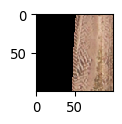

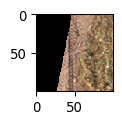

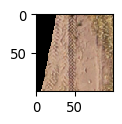

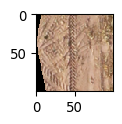

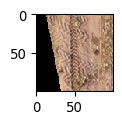

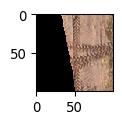

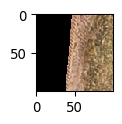

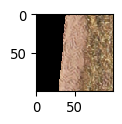

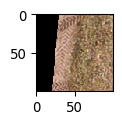

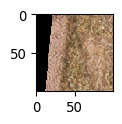

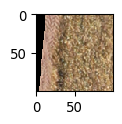

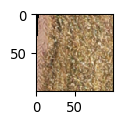

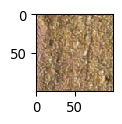

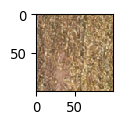

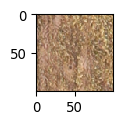

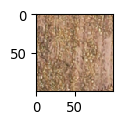

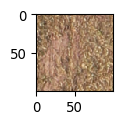

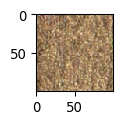

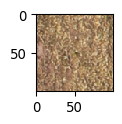

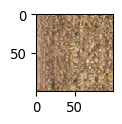

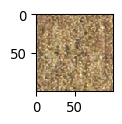

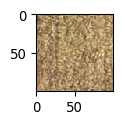

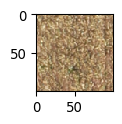

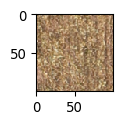

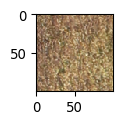

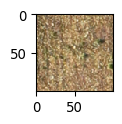

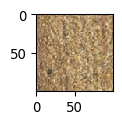

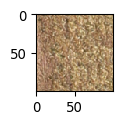

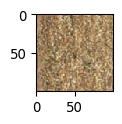

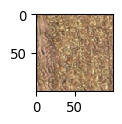

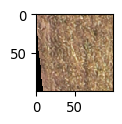

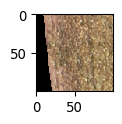

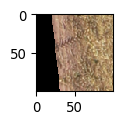

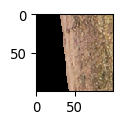

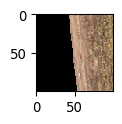

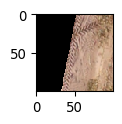

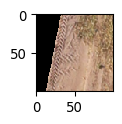

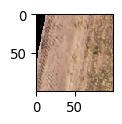

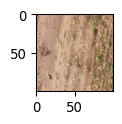

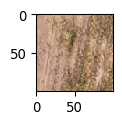

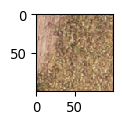

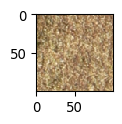

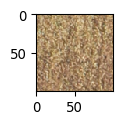

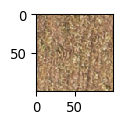

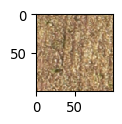

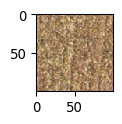

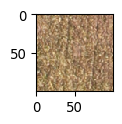

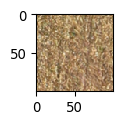

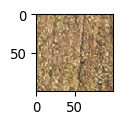

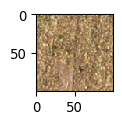

KeyboardInterrupt: 

In [94]:
init_x = int(mosaico.RasterXSize / 2)
init_y = int(mosaico.RasterYSize / 2)

max_x = int(mosaico.RasterXSize / 4)
max_y = int(mosaico.RasterYSize / 4)

path_neural_network = '../neural_network/supervisionated/misto_weedraw_encontradas/vgg16_Linknet_2.hdf5'
path_orthomosaic = '../../daninhas/ortomosaicos/pre-emergente/179323/ortomosaico.tif'

predict_orthomosaic(path_neural_network, path_orthomosaic ,0, 0,
                   increment_x=100, increment_y=100, box_prediction=True)

16309 9322 8154 4661


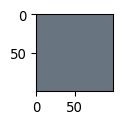

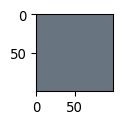

In [154]:
init_x = int(mosaico.RasterXSize / 2)
init_y = int(mosaico.RasterYSize / 2)

max_x = int(mosaico.RasterXSize / 4)
max_y = int(mosaico.RasterYSize / 4)
print(init_x, init_y, max_x, max_y)

array = estimate_dominant_color_orthomosaic(mosaico, init_x, init_y, max_x=init_x+512, max_y=init_y+512, 
                                            consider_black=True, show_img=True)


array = estimate_dominant_color_orthomosaic(mosaico, init_x, init_y, max_x=init_x+512, max_y=init_y+512, 
                                            consider_black=False, show_img=True)